'----------------------------------------------------------------------------------------------------

# Module 9 Part 2: Building Models with Tensorflow

- 1 Introduction
- 2 Learning Objectives
- 3 Reading and Resources
- 4 Model Construction
    - 4.1 Manual Gradient Descent
    - 4.1 Tf.autodiff 
    - 4.2 tf optimizers
- 5 Model Execution
    - 5.1 Mini Batch Gradient Descent
    - 5.2 Early stopping
    - 5.2 Saving & Restoring models
- 6 Visualizing Models with Tensorboard

# Introduction
TBD



# Learning Outcomes

In this module, you will:

* TBD

# Readings and Resources

The majority of the notebook content borrows from the recommended readings. We invite you to further supplement this notebook with the following recommended texts:

- TBD
- https://jacobbuckman.com/post/tensorflow-the-confusing-parts-1/


# A simple first model with Tensorflow

Tensorflow models are typically a little more cumbersome to implement than the simple sklearn api. However this complexity also allows for more finely tuned models and complex implementation. To begin, it is important to note that tensorflow models are typically split into two parts:

1. First part builds a computaiton graph (this is called constructrion phase). 
    - Setting up the input variables
    - Definine the loss function
    - Initializing and calling the training_op or optimizer
2. Second part runs it (execution phase):
    - Looping through the model n epochs
    - Updating weights based on using the entire training set or mini-batches
    - Prining and storing training/validation loss values periodically for visualization
    - Saving the model periodically
    
We will dive into 

To get you more familiar with tensorflows functionality, we will start be constructing a graph that manually implements batch gradient descent. Then we will use TensorFlow’s autodiff feature to let TensorFlow compute the gradients automatically. Lastly, we will use a couple of TensorFlow’s out-of-the-box optimizers. 


Remember, when using Gradient Descent, it is almost always very important to first normalize the input feature vectors, or else training may be much slower (or not converge at all). To do this we will use sklearn `StandardScaler`, however you may use any implementation you like.

**The Dataset:**

We are going to work with the well-known iris dataset provided by sklearn.datasets to build our first model. Note that using tensorflow for a simple logistic regression like this is somewhat overkill, as the dataset is small and the model is simple. As noted above, the main benefit of TensorFlow is that it is easily distributed and parallelzied, which is really only becomes important with very complex models with massive datasets. That said, we will use this simple example to illustrate the process of developing, executing, and making predictions with a tensorflow model.

Let's start by loading in the data:

In [336]:
#load data
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

X_iris = iris["data"]  # petal length, petal width
y_iris = iris["target"]#.reshape((-1,1))

# Normalize the data
scaler = StandardScaler()
X_iris = scaler.fit_transform(X_iris)

# Add bias term
X_iris = np.c_[np.ones((X_iris.shape[0],1)), X_iris]

# Train test split
X_train, X_val, y_train, y_val = train_test_split(X_iris, y_iris, test_size=0.2, shuffle=True)

# Print shape of final dataset
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)

X_train: (120, 5)
X_val: (30, 5)
y_train: (120,)
y_val: (30,)


## Manually Processing Gradients

For this model, we will simply manually derive the gradients and input the formulas into the graph. Most of the bode below should be fairly self explanatory, as we are simply executing a multi-class softmax regression using using tensorflow's built in matrix manipulation functions. Let's quickly review the main steps in the code:
- **STEP 1:** First we simply set some key hyperparameters, including the `learning_rate`, `m` (number of observations), and `n` (number of features) 
- **STEP 2:** Next we set up our placeholder nodes for the X and y values. Note the use of `None` in the shape argument. **This tells tensorflow that we want to leave this dimension ambiguous when we feed data into our graph so we can enter any number of observations (rows)**. This will become increasingly important when perfoming mini-batch gradient descent (as you will see shortly). In this step we also convert the y values to one hot encoding using `tf.one_hot`
- **STEP 3:** Here we set our trainable variables, using `random_normal` initialization. We set the dimensions to `[n, n_classes]` as is standard for softmax regression.
- **STEP 4**: Now we calculate the logits, the softmax output (y_proba), and the log loss, all using tensorflow's basic math operations
- **STEP 5**: Lastly we calculate the gradients and update the `W` node accordingly using the `tf.assign` function. Remember that a tensorflow variable will persist between runs, as long as the session remains open **(the values are held in the session, NOT the graph)** 

Note that we set the names of each of our tensorflow objects.

In [396]:
from tensorflow.initializers import random_normal
tf.reset_default_graph()

# STEP 1: Set the number of parameters
m, n = X_train.shape 
n_classes = len(np.unique(y_train))
learning_rate = 0.01
epsilon = 1e-7 # epsilon is added to loss function

# STEP 2: Add placeholder nodes for inputs
X = tf.placeholder(dtype=tf.float32, shape=(None, n))
y = tf.placeholder(dtype=tf.int32, shape=(None))
y_one_hot = tf.one_hot(y, n_classes)

# STEP 3: Add variable nodes for weights
W = tf.get_variable(name='weights', shape=[n, n_classes], initializer=random_normal) #initialize first rand theta

# STEP 4: Calculate softmax outputs 
logits = tf.matmul(X, W)
y_proba = tf.exp(logits) / tf.reshape(tf.reduce_sum(tf.exp(logits), axis=-1),(-1,1)) # Sum over last index
log_loss = -tf.reduce_mean(tf.reduce_sum(y_one_hot * tf.log(y_proba+epsilon), axis=-1))

# STEP 5: Gradient descent calculations
error = y_proba - y_one_hot
gradients = 1/m * tf.matmul(tf.transpose(X),error)
training_op = tf.assign(W, W - learning_rate * gradients)

init = tf.global_variables_initializer() #initialize all variables

Great, now that our graph is set up, lets run a couple iterations of gradient decent! To do this, we simply **set the number of epochs we want to run our model for**, and loop through the graph re-running the `training_op` each time. This will iteratively recalculate the gradients, and also update the `W` values, thus performing gradient descent. 

You will also want to save the value of the updated `W` tensor for later so that they can be used to make predictions.

Lastly, we will wrap the code in a function so that we can easily re-train future models with a single line of code.

Epoch 0 Train Loss = 1.2740346 Validation Loss = 1.5235271
Epoch 250 Train Loss = 0.49557117 Validation Loss = 0.5761351
Epoch 500 Train Loss = 0.37633643 Validation Loss = 0.40810668
Epoch 750 Train Loss = 0.33446354 Validation Loss = 0.3522386
Epoch 1000 Train Loss = 0.30926389 Validation Loss = 0.32322076
Epoch 1250 Train Loss = 0.2904952 Validation Loss = 0.3032888
Epoch 1500 Train Loss = 0.2751774 Validation Loss = 0.2874471
Epoch 1750 Train Loss = 0.26210678 Validation Loss = 0.27396393
Epoch 2000 Train Loss = 0.25067726 Validation Loss = 0.262107
Epoch 2250 Train Loss = 0.24053055 Validation Loss = 0.2515028


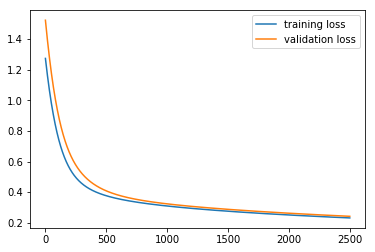

In [395]:
import matplotlib.pyplot as plt

def train_model(X_train, y_train, X_val, y_val, epochs=2500, ):
    # Open a session
    with tf.Session() as sess:
        # Initialize variables
        sess.run(init)
        train_losses = []
        val_losses = []
        # Loop through the graph for n epochs
        for epoch in range(epochs):
            # Update weights and save W_update for later!
            _, train_loss, W_update = sess.run([training_op, log_loss, W], feed_dict={X:X_train, y:y_train})
            # Get validation loss
            val_loss = sess.run(log_loss, feed_dict={X:X_val, y:y_val})
            # Save incremental loss values for visualization
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            # Print results evey 100 runs
            if epoch % 250 == 0:
                print("Epoch", epoch, "Train Loss =", train_loss, "Validation Loss =", val_loss)
    # Plot loss values
    plt.plot(train_losses, label='training loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
    plt.show()
    
train_model(X_train, y_train, X_val, y_val)

Great! Both our training and validation loss decrease steadily. This makes sense as this is simple convex optimizaiton problem.

Now let's use our newly trained model to make some predictions. Note that we can't simply open a session and call `sess.run(y_proba, feed_dict={X:X_test)`. First of all, this won't work because we will be trying to run a graph with uninitialized variables. Rememeber that when the session closes after the `with` block ends, the all of the values in the graph are lost. It is for this reason that we specifically called the `W` node and saved it as `W_update` in the session run above. This should result in updated weight values below:

In [352]:
print('bias:', W_update[0])
print('coefficients:', W_update[1:])

bias: [-1.1765492  0.8311525 -0.7406013]
coefficients: [[-1.573865   -0.51795053 -1.266641  ]
 [ 0.21403034 -0.9260183   0.12190595]
 [-1.1375742  -0.4995983   2.2689314 ]
 [-2.2503598  -0.22541033  1.1074305 ]]


Now all we have to do is feed these weight values into the our graph using `tf.assign` in a session run, and we can feed in some prediction data. We will also use a confusion matrix here to quickly see how our model is performing. Once again we will wrap this code in a function for easy-made predictions for future models:

In [364]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def make_predictions(X_test, y_test, W_update=W_update):
    """Use trained model weights to make predictions"""
    with tf.Session() as sess:
        # Note that you could also simple enter 'W:W_update' into the feed_dict argument below 
        sess.run(tf.assign(W, W_update))
        # Feed in the test data and select the high probability as the prediction
        predictions = sess.run(tf.argmax(y_proba, axis=-1), feed_dict={X:X_test})
    # Show the confusion matrix
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Confusion Matrix:\n",confusion_matrix(y_test, predictions))

make_predictions(X_iris, y_iris)

Accuracy: 0.9333333333333333
Confusion Matrix:
 [[50  0  0]
 [ 0 43  7]
 [ 0  3 47]]


## Using tf.autodiff

Look at that accuracy! Not bad for a manually derived gradient descnet model. But deriving the gradients for a softmax or linear regression is fairly easy. This is not the case for multi-layer deep neural networks (which we will cover in the next session). **You probably could use symbolic differentiaion to automatically find the equations for the partial derivatives for you, but the resulting code would not necessarily be very efficient.**

# V TO HELP WITH THIS
To understand why, consider the function f(x)= exp(exp(exp(x))). If you know calculus, you can figure out its derivative f′(x) = exp(x) × exp(exp(x)) × exp(exp(exp(x))). If you code f(x) and f′(x) separately and exactly as they appear, your code will not be as efficient as it could be. A more efficient solution would be to write a function that first computes exp(x), then exp(exp(x)), then exp(exp(exp(x))), and returns all three. This gives you f(x) directly (the third term), and if you need the derivative you can just multiply all three terms and you are done. With the naïve approach you would have had to call the exp function nine times to compute both f(x) and f′(x). With this approach you just need to call it three times.

**It gets worse when your function is defined by some arbitrary code. Can you find the equation (or the code) to compute the partial derivatives of the following function? Hint: don’t even try.** 

    def my_func(a, b):
        z = 0
        for i in range(100):
            z = a * np.cos(z + i) + z * np.sin(b - i)
        return z

Forutunately, TF's **autodiff** feature comes to the rescue: **it can automatically and efficiently compute the gradients for you.** All you have to do is replace this code:

    error = y_proba - y_one_hot
    gradients = 1/m * tf.matmul(tf.transpose(X),error)
    
with the much simpler code below:

    gradients = tf.gradients(log_loss,W)[0] 

Note that we Let's see how this looks in our graph:

In [389]:
#################################### Same code as above ####################################
tf.reset_default_graph()
m, n = X_train.shape 
n_classes = len(np.unique(y_train))
learning_rate = 0.01
epsilon = 1e-7 

X = tf.placeholder(dtype=tf.float32, shape=(None, n))
y = tf.placeholder(dtype=tf.int32, shape=(None))
y_one_hot = tf.one_hot(y, n_classes)

W = tf.get_variable(name='weights', shape=[n, n_classes], initializer=random_normal)
logits = tf.matmul(X, W)
y_proba = tf.exp(logits) / tf.reshape(tf.reduce_sum(tf.exp(logits), axis=-1),(-1,1))
log_loss = -tf.reduce_mean(tf.reduce_sum(y_one_hot * tf.log(y_proba+epsilon), axis=-1))
############################################################################################

# Updated code using tf.gradients
gradients = tf.gradients(log_loss,W)[0]
training_op = tf.assign(W, W - learning_rate * gradients)

init = tf.global_variables_initializer() 

Lets run our train our model and test it out using the `train_model` and `make_predictions` functions we defined above:

Epoch 0 Train Loss = 1.3706197 Validation Loss = 1.4298096
Epoch 250 Train Loss = 0.49090794 Validation Loss = 0.51762146
Epoch 500 Train Loss = 0.3955326 Validation Loss = 0.42005444
Epoch 750 Train Loss = 0.3526084 Validation Loss = 0.37729663
Epoch 1000 Train Loss = 0.32426098 Validation Loss = 0.34904802
Epoch 1250 Train Loss = 0.30261526 Validation Loss = 0.32730454
Epoch 1500 Train Loss = 0.28495607 Validation Loss = 0.3093898
Epoch 1750 Train Loss = 0.27001745 Validation Loss = 0.29408315
Epoch 2000 Train Loss = 0.2570921 Validation Loss = 0.28071535
Epoch 2250 Train Loss = 0.2457346 Validation Loss = 0.26886967


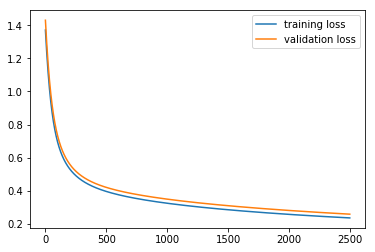

Accuracy: 0.9333333333333333
Confusion Matrix:
 [[50  0  0]
 [ 0 43  7]
 [ 0  3 47]]


In [390]:
# Train model
train_model(X_train, y_train, X_val, y_val)
# Test Model
make_predictions(X_iris, y_iris)

Evidently, computing gradients using `tf.gradients` is much easily than manually deriving and consturcting the graph yourself. 

Below is a list of the **main approaches to computing gradients automatically.** As mentioned above, Tensorflow useses reverse-mode autodiff, which works best (in terms of efficiency and accuracy) when there are a high number of inputs and only few outputs (which is usually the case for most deep learning applications). Reverse-mode autodiff can compute all of the partial derivatives of the outputs with regards to all the inputs in just **n outputs + 1 graph traversals**. 

<img src='images/c4_m9_p1_graph5.png' style="float:left;width:600px;height:400;">

We won't go into the heavy details of how these techniques work, but you are encouraged do so yourself. Aurélien Geron offers an excellent introcution to the topic on his Github, found [here](https://github.com/ageron/handson-ml/blob/master/extra_autodiff.ipynb).

## Using `tf.train` optimizers

If that wasn't easy enough for you, tensorflow also provides a number of optimizers out of the box, including a Gradient Descent optimizer. This will allow you to replace a your manual `W` paramater update code:
 
    gradients = tf.gradients(log_loss,W)[0] 
    training_op = tf.assign(W, W - learning_rate * gradients)

with the much cleaner `tf.train` optimizer code:

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss=log_loss)

Note that we first intialize the optimizer sthen call it using the `minimize` method, passing in the cost function tensor that we would like minimize. 


In [392]:
#################################### Same code as above ####################################
tf.reset_default_graph()
m, n = X_train.shape 
n_classes = len(np.unique(y_train))
learning_rate = 0.01
epsilon = 1e-7 

X = tf.placeholder(dtype=tf.float32, shape=(None, n))
y = tf.placeholder(dtype=tf.int32, shape=(None))
y_one_hot = tf.one_hot(y, n_classes)

W = tf.get_variable(name='weights', shape=[n, n_classes], initializer=random_normal)
logits = tf.matmul(X, W)
y_proba = tf.exp(logits) / tf.reshape(tf.reduce_sum(tf.exp(logits), axis=-1),(-1,1))
log_loss = -tf.reduce_mean(tf.reduce_sum(y_one_hot * tf.log(y_proba+epsilon), axis=-1))
############################################################################################

# Updated code using tf.train
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(log_loss)

init = tf.global_variables_initializer() 

Epoch 0 Train Loss = 0.7458341 Validation Loss = 0.8414053
Epoch 250 Train Loss = 0.5618462 Validation Loss = 0.5773586
Epoch 500 Train Loss = 0.49345848 Validation Loss = 0.48946488
Epoch 750 Train Loss = 0.44611704 Validation Loss = 0.43759152
Epoch 1000 Train Loss = 0.40793115 Validation Loss = 0.3990794
Epoch 1250 Train Loss = 0.37568626 Validation Loss = 0.36788952
Epoch 1500 Train Loss = 0.34803805 Validation Loss = 0.34178433
Epoch 1750 Train Loss = 0.32419997 Validation Loss = 0.31962973
Epoch 2000 Train Loss = 0.30358478 Validation Loss = 0.30067784
Epoch 2250 Train Loss = 0.285699 Validation Loss = 0.28435484


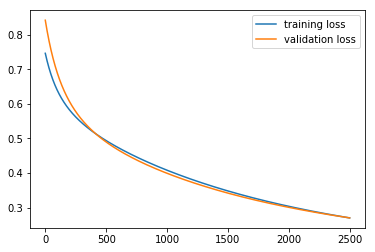

Accuracy: 0.9333333333333333
Confusion Matrix:
 [[50  0  0]
 [ 0 43  7]
 [ 0  3 47]]


In [393]:
# Train model
train_model(X_train, y_train, X_val, y_val)
# Test Model
make_predictions(X_iris, y_iris)

**REWRITE:** If you want to use a different type of optimizer, you just need to change one line. **For example, you can
use a momentum optimizer (which often converges much faster than Gradient Descent) by defining the optimizer like this:**

# Model Execution

## Batch Gradient Descent

TBD

## Mini-Batch Gradient Descent

TBD

## Saving and restoring models

TBD

# Visualizing TF Models with Tensorboard

## Tensorboard overview and setup

TBD

## Using Namescores

TBD

In [276]:
tf.argmax

<function tensorflow.python.ops.math_ops.argmax(input, axis=None, name=None, dimension=None, output_type=tf.int64)>

In [280]:
from sklearn.metrics import confusion_matrix
with tf.Session() as sess:
    sess.run(tf.assign(W, W_update))
    predictions = sess.run(tf.argmax(y_proba, axis=-1), feed_dict={X:X_train})

confusion_matrix(y_train, predictions)
#plt.show()
#predictions.shape

array([[41,  0,  0],
       [ 0, 35,  3],
       [ 0,  3, 38]], dtype=int64)

# EXTRA INFO: find place to include?